## CIFAR10图像分类
### 微调实现

In [4]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as T
import os
import shutil
import collections
import math
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from d2l import torch as d2l

data_dir = '../data/cifar-10'

train_transform = T.Compose([
    T.Resize(40),
    T.RandomResizedCrop(32, scale=(0.64, 1), ratio=(1.0, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(
        [0.4919, 0.4822, 0.4465],
        [0.2023, 0.1994, 0.2010]
    )
])
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        [0.4919, 0.4822, 0.4465],
        [0.2023, 0.1994, 0.2010]
    )
])

In [14]:
batch_size = 128 if len(d2l.try_all_gpus()) > 1 else 64
train_ds, train_valid_ds = [ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), 
                                        transform=train_transform) for folder in ['train', 'train_valid']]
valid_ds, test_ds = [ImageFolder(os.path.join(data_dir, "train_valid_test", folder), 
                                 transform=test_transform) for folder in ['valid', 'test']]
# init the dataloader
train_iter, train_valid_iter = [DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
                                for dataset in [train_ds, train_valid_ds]]
valid_iter, test_iter = [DataLoader(dataset, batch_size, shuffle=False, drop_last=False)
                         for dataset in [valid_ds, test_ds]]

In [6]:
pretrained_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
pretrained_net.fc = nn.Linear(pretrained_net.fc.in_features, 10)
nn.init.xavier_normal_(pretrained_net.fc.weight)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Parameter containing:
tensor([[-0.0092,  0.0978, -0.0277,  ..., -0.0662, -0.0265, -0.0059],
        [ 0.0158, -0.0452, -0.0308,  ..., -0.1214, -0.0547, -0.0649],
        [ 0.0354, -0.0021,  0.0334,  ..., -0.0247, -0.0089,  0.0527],
        ...,
        [-0.0574,  0.0634,  0.0164,  ...,  0.0075,  0.0080,  0.0436],
        [ 0.0219,  0.0976, -0.0081,  ..., -0.0135, -0.0206,  0.0508],
        [-0.1019,  0.0389,  0.0191,  ...,  0.0565,  0.0255, -0.0552]],
       requires_grad=True)

In [7]:
loss = nn.CrossEntropyLoss(reduction='none')

In [8]:
def train_fine_tuning(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    params_pretrained = [param for name, param in net.named_parameters() if name not in ['fc.weight', 'fc.bias']]
    trainer = torch.optim.SGD([
        {'params':params_pretrained, 'lr':lr},
        {'params':net.fc.parameters(), 'lr':lr * 10}
    ], lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    if len(devices) > 1:
        net = nn.DataParallel(net, devices).to(devices[0])
    else:
        net = net.to(*devices)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if i % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (metric[0] / metric[2], metric[1]/ metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.186, train acc 0.935
3979.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


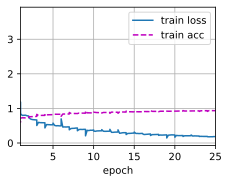

In [9]:
lr_period = 4
lr_decay = 0.9
devices = d2l.try_all_gpus()
num_epochs = 25
lr = 2e-5
wd = 5e-4
# train_fine_tuning(pretrained_net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)
train_fine_tuning(pretrained_net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

In [10]:
torch.save(pretrained_net, '../checkpoints/resnet18_cifar10_finetune.pth')

In [15]:
preds = []
for X, _ in test_iter:
    y_hat = pretrained_net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
    


In [16]:
len(preds)

300000

In [17]:
import pandas as pd
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x:str(x))
df = pd.DataFrame({'id':sorted_ids, 'label':preds})
df['label'] = df['label'].apply(lambda x:train_valid_ds.classes[x])
df.to_csv('submission_cifar10_finetuning.csv', index=False)